In [184]:
import numpy as np
import matplotlib.pyplot as plt

In [185]:
# Parameters
DECK_SIZE = 52
HAND_SIZE = 13
N_TRIALS = 10000

In [186]:
# Calculate largest gap in circular array
def calc_largest_gap(slots, n_slots):
    # Sort the chosen slots
    slots_sorted = np.sort(slots)
    # Calculate gaps between consecutive slots
    gaps = np.diff(slots_sorted, append=slots_sorted[0] + n_slots)
    return np.max(gaps)

In [187]:
# Calculate gaps at both ends of linear array
def calc_end_gaps(slots, n_slots):
    # Sort the chosen slots
    slots_sorted = np.sort(slots)
    # Calculate gaps for both ends
    lower_end_gap = slots_sorted[0]
    upper_end_gap = n_slots - slots_sorted[-1]
    # Calculate gaps at both ends
    return lower_end_gap + upper_end_gap

In [188]:
# Find min and max in wrapped array
def reorder_hand(slots, n_slots):
    # Sort the chosen slots
    slots_sorted = np.sort(slots)
    # Find min and max in wrapped array
    max_gap = 0
    min_idx = None
    max_idx = None
    for i in range(len(slots_sorted) - 1):
        gap = slots_sorted[i+1] - slots_sorted[i]
        if gap > max_gap:
            max_gap = gap
            min_idx = slots_sorted[i+1]
            max_idx = slots_sorted[i]
    
    # Check wrap-around gap
    wrap_around_gap = slots_sorted[0] + n_slots - slots_sorted[-1]
    if wrap_around_gap > max_gap:
        max_gap = wrap_around_gap
        min_idx = slots_sorted[0]
        max_idx = slots_sorted[-1]

    start_idx = np.where(slots_sorted == min_idx)[0][0]
    reordered_slots = np.concatenate((slots_sorted[start_idx:], slots_sorted[:start_idx]))

    return reordered_slots

In [189]:
# Compute cards eliminated in wraparound min-max by round
def wrap_elimination(hand):
    elim_count_by_round = np.zeros(HAND_SIZE - 1)
    min_idx = None
    max_idx = None
    
    for i in range(HAND_SIZE - 1):
        if i % 2 == 0:
            min_idx = hand.pop(0)
            if i == 0:
                elim_count_by_round[i] = 3
            else:
                elim_count_by_round[i] = (min_idx - max_idx) % DECK_SIZE - 1
        else:
            max_idx = hand.pop(-1)
            elim_count_by_round[i] = (min_idx - max_idx) % DECK_SIZE - 1

    return elim_count_by_round

In [190]:
# Compute cards eliminated in linear min-max by round
def linear_elimination(hand):
    elim_count_by_round = np.zeros(HAND_SIZE - 1)
    min_idx = None
    max_idx = None

    for i in range(HAND_SIZE - 1):
        if i % 2 == 0:
            min_idx = hand.pop(0)
            if i == 0:
                elim_count_by_round[i] = min_idx
            else:
                elim_count_by_round[i] = min_idx + DECK_SIZE - max_idx - 1
        else:
            max_idx = hand.pop(-1)
            elim_count_by_round[i] = min_idx + DECK_SIZE - max_idx - 1

    return elim_count_by_round

In [191]:
# Simulate the process
largest_gaps = []
end_gaps = []
cards_eliminated_wrap = np.zeros((N_TRIALS, HAND_SIZE - 1))
cards_eliminated_linear = np.zeros((N_TRIALS, HAND_SIZE - 1))

for i in range(N_TRIALS):
    # Randomly choose 13 unique slots
    chosen_hand = np.random.choice(DECK_SIZE, HAND_SIZE, replace=False)

    # Calculate the largest gap
    gap = calc_largest_gap(chosen_hand, DECK_SIZE)
    ends = calc_end_gaps(chosen_hand, DECK_SIZE)
    largest_gaps.append(gap)
    end_gaps.append(ends)

    # Reorder hand based on wrap-around min-max
    reordered_hand = reorder_hand(chosen_hand, DECK_SIZE)
    sorted_hand = np.sort(chosen_hand)

    # Compute cards eliminated in both cases
    cards_eliminated_wrap[i, :] = wrap_elimination(list(reordered_hand))
    cards_eliminated_linear[i, :] = linear_elimination(list(sorted_hand))

# Calculate the average largest gap
expected_largest_gap = np.mean(largest_gaps)
expected_end_gaps = np.mean(end_gaps)
print(f'Expected largest gap: {expected_largest_gap}, expected end gaps: {expected_end_gaps}, difference: {expected_largest_gap - expected_end_gaps}')

# Calculate the average number of cards eliminated in both cases
expected_cards_eliminated_wrap = np.mean(cards_eliminated_wrap, axis=0)
expected_cards_eliminated_linear = np.mean(cards_eliminated_linear, axis=0)
difference = expected_cards_eliminated_wrap - expected_cards_eliminated_linear
cumulative_difference = np.cumsum(difference)
print(f'Expected cards eliminated in wrap-around min-max: {expected_cards_eliminated_wrap}')
print(f'Expected cards eliminated in linear min-max: {expected_cards_eliminated_linear}')
print(f'Difference: {difference}')


Expected largest gap: 11.5509, expected end gaps: 6.5422, difference: 5.0087
Expected cards eliminated in wrap-around min-max: [ 3.     10.5509 13.9851 17.3529 20.7378 24.0839 27.4621 30.8261 34.2104
 37.5225 40.9177 44.2507]
Expected cards eliminated in linear min-max: [ 2.769   5.5422  9.363  13.1618 16.8924 20.653  24.4644 28.2501 32.05
 35.8375 39.6183 43.3936]
Difference: [0.231  5.0087 4.6221 4.1911 3.8454 3.4309 2.9977 2.576  2.1604 1.685
 1.2994 0.8571]


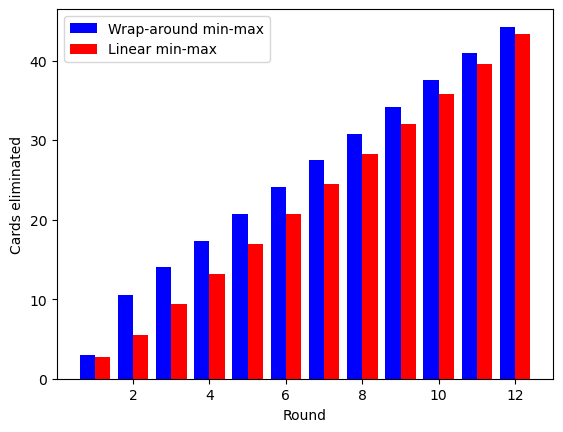

In [192]:
# Plot comparison of cards eliminated by round
rounds = np.arange(1, HAND_SIZE)
bar_width = 0.4
r1 = rounds - bar_width / 2
r2 = rounds + bar_width / 2

plt.bar(r1, expected_cards_eliminated_wrap, width=bar_width, color='b', label='Wrap-around min-max')
plt.bar(r2, expected_cards_eliminated_linear, width=bar_width, color='r', label='Linear min-max')
plt.xlabel('Round')
plt.ylabel('Cards eliminated')
plt.legend()
plt.savefig('cards_eliminated.png')
plt.show()

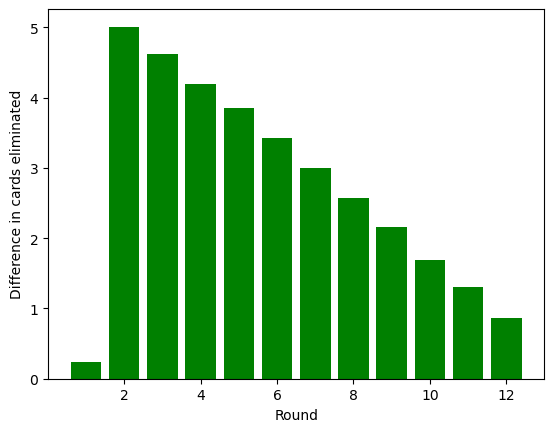

In [193]:
# Plot difference in cards eliminated by round
plt.bar(rounds, difference, color='g')
plt.xlabel('Round')
plt.ylabel('Difference in cards eliminated')
plt.savefig('difference.png')
plt.show()

In [194]:
# Simulations against each group, playing as NS
scores_wrap = [
    (85.84, 95.27),
    (85.32, 82.69),
    (85.61, 89.89),
    (88.91, 87.34),
    (85.72, 96.17),
    (85.83, 92.08),
    (85.11, 88.39),
    (89.17, 88.27),
    (85.47, 94.64),
    (91.17, 91.38)
]

scores_linear = [
    (82.02, 95.04),
    (81.42, 83.29),
    (81.46, 89.61),
    (76.56, 85.19),
    (82.31, 96.81),
    (83.81, 93.40),
    (81.63, 87.13),
    (83.64, 86.53),
    (82.19, 95.18),
    (74.81, 74.33)
]

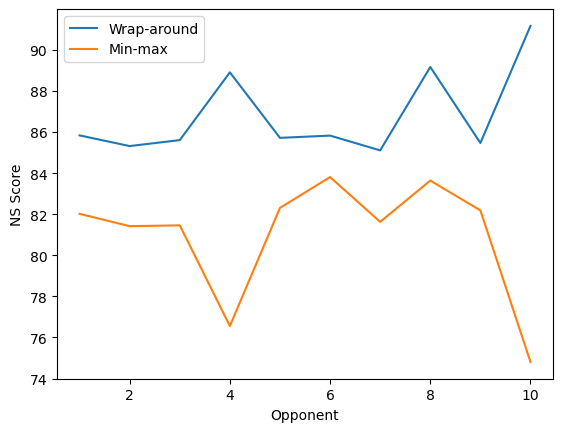

In [195]:
# Graph first value of each tuple in scores_wrap and scores_linear as seperate lines
opponents = np.arange(1, 11)
plt.plot(opponents, [score[0] for score in scores_wrap], label='Wrap-around')
plt.plot(opponents, [score[0] for score in scores_linear], label='Min-max')
plt.xlabel('Opponent')
plt.ylabel('NS Score')
plt.legend()
plt.savefig('scores.png')
plt.show()

In [199]:
# Average score difference
NS_scores_wrap = [score[0] for score in scores_wrap]
NS_scores_linear = [score[0] for score in scores_linear]
difference = np.array(NS_scores_wrap) - np.array(NS_scores_linear)
average_difference = np.median(difference)
print(f'Median score difference: {average_difference}')

Median score difference: 3.8599999999999994
